# Single Run Analysis

This notebook takes a single output of the 2D_SI_DNS dedalus run. Makes descriptive plots for the manuscript.

Author: Jacob Wenegrat
12-02-2019

In [90]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.special as special
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## Load variables

In [91]:
#%% Pick the filename and path

###################### CI RUN ############################
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5' #0.1 slope
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p1/snapshots/snapshots_1e-5_0p1_MS.h5' #0.1 slope

NameAppend='CI-1'
visc = 1e-4
Vi = 0.1

###################### SI RUN ############################
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5' #Ruan case F
#NameAppend='SI-1'
#visc = 1e-4
#Vi = 0.1

################## CONVECTIVE RUN ###########################
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5' #Ruan case F
#NameAppend='CONV-1'
#visc = 1e-4
#Vi = 0.1


SAVEFLAG = False # Turn on to savefigs



f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'][0,0,0] # Slope angle

S2 = N**2*tht**2/1e-8
# Load variables in physical space
u = f['tasks']['u'] # Cross-slope direction
v = f['tasks']['v'] # Along-slope direction
w = f['tasks']['w'] # Slope-normal direction
b = f['tasks']['b'] # Perturbation buoyancy

qa = f['tasks']['PVa']
q = f['tasks']['PV']
wq = f['tasks']['wq']
# Energy terms 
gsp = f['tasks']['GSP']
gspr = f['tasks']['GSProtated']
vspu = f['tasks']['VSPu']
vspv = f['tasks']['VSPv']
vsp = vspu[:,:,:]+vspv[:,:,:]
lspu = f['tasks']['LSPu']
lspv = f['tasks']['LSPv']
lsp = lspu[:,:,:] + lspv[:,:,:]
diss = f['tasks']['Diss']
vbf = f['tasks']['VBF']
vbfr = f['tasks']['VBFr']
hbfr = f['tasks']['HBFrotated']
hbfr = hbfr*np.sin(tht)
vbfrot = f['tasks']['VBFrotated']
sp = f['tasks']['SP']
EKE = f['tasks']['EKE']
try:
    upwp = f['tasks']['UPWP']
    vpwp = gspr[:,0,:]*1e-4/(N**2*np.sin(tht))
    # SPECTRAL QUANTITIES
    ws = f['tasks']['ws']
    bs = f['tasks']['bs']
    vs = f['tasks']['vs']
except:
    ws = f['tasks']['wcs']
    bs = f['tasks']['bs']
    vs = f['tasks']['vcs']
    print('Could not load flux terms')



# Domain parameters
x = u.dims[1][0][:]
z = u.dims[2][0][:]
time = u.dims[0][0][:]
kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction

In [92]:
print(time[-1]/86400)
print(x[-1])


39.979231999927705
999.0234375


In [93]:
# Calculated quantities
va = np.mean(v, axis=1)

qm = np.mean(q, axis=1) 
bm = np.mean(b, axis=1)
bxc = np.gradient(b, axis=1)/np.gradient(x[np.newaxis, :,np.newaxis], axis=1)*np.cos(tht)- np.gradient(b, axis=-1)/np.gradient(z[np.newaxis, np.newaxis,:], axis=-1)*np.sin(tht) #f['tasks']['bxs']
bx = np.gradient(b, axis=1)/np.gradient(x[np.newaxis, :, np.newaxis], axis=1)
bxcm = np.mean(bxc, axis=1)
bxm = np.mean(bx, axis=1)

bzr = np.gradient(bm, axis=-1)/np.gradient(z)*np.cos(tht) + bxcm*np.sin(tht) + N**2

um = np.mean(u, axis=1)
vm = np.mean(v, axis=1)
up = u - um[:,np.newaxis,:]
vp = v - vm[:,np.newaxis,:]

uz = np.gradient(um, axis=-1)/np.gradient(z)
vz = np.gradient(vm, axis=-1)/np.gradient(z) 
wz = np.gradient(np.mean(w, axis=1), axis=-1)/np.gradient(z)
zm = z-z[-1]
qt = np.transpose(np.transpose(np.gradient(qm, axis=0))/np.gradient(time))
qta = np.gradient(qa[:,0,0])/np.gradient(time)
bb = x[np.newaxis,:,np.newaxis]*N**2*np.sin(tht) + N**2*np.cos(tht)*z[np.newaxis, np.newaxis,:]
bf = b + bb
bz = np.gradient(bm, axis=-1)/np.gradient(z) + N**2
bz_prime = np.gradient(bm, axis=-1)/np.gradient(z)
Ri = bz/(uz**2 + vz**2)



#zetaprimebprime = np.mean((bf - np.mean(bf,axis=1))*(np.gradient(v, axis=1)/np.gradient(x)), axis=1)
uz = np.gradient(u, axis=-1)/np.gradient(z)
vz = np.gradient(v, axis=-1)/np.gradient(z)
EKEt = np.gradient(EKE[:,0,:], axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MKE = 0.5*(um**2 + (vm)**2)
MKEt = np.gradient(MKE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MAPE = 0.5*np.mean(b[:,:,:]**2, axis=1)/N**2
MAPEt = np.gradient(MAPE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

# SPECTRAL
try:
    gsps = 2*np.real(-np.conj(vs)*ws*bxcm[:,np.newaxis,:]/1e-4)
    vbfs = 2*np.real(np.conj(ws)*bs)
    wbs = 2*np.real(np.conj(ws)*bs)
    wvs = 2*np.real(np.conj(ws)*vs)
except:
    print('Could not calculate spectral fluxes.')

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


## Estimate bottom stress and Ekman transport

The bottom stress is needed to calculate the cross-slope Ekman transport. 
There are several ways to calculate this. The first is directly, given that we resolve the viscous layer ($\delta_v = \nu/u^*$).
\begin{equation}
\tau_y = \rho \nu \frac{\partial v}{\partial z}
\end{equation}
where $\nu$ is the subgrid viscosity.

The other way (which would in some sense be preferable for observational purposes, would be using a drag coefficient:
\begin{equation}
\tau_y = \rho C_d \sqrt{u^2 + v^2}v
\end{equation}
This appears to work reasonably well, however it has to be evaluated on the order of meters above the bottom. Not sure how this is supposed to actually be evaluated (ie. is there a principled way to pick the depth?).

Using these the cross-slope Ekman transport is given by,

\begin{equation}
B_{Ek} = \frac{\tau_y}{\rho_o f(1+S^2)} N^2 \sin{\theta}
\end{equation}

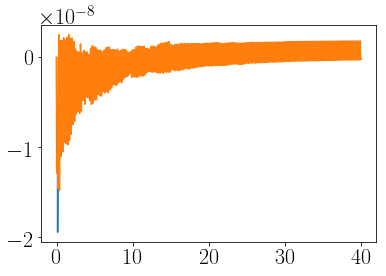

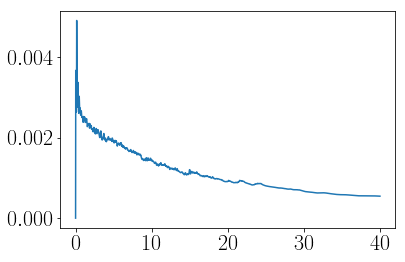

In [94]:

uss = visc*np.sqrt(np.mean(uz[:,:,0]**2 + vz[:,:,0]**2, axis=1))
us = np.sqrt(uss)
usm = np.mean(us)
delv = visc/usm

tauy = -1035*visc*np.mean(vz[:,:,0], axis=1) #Note that 1e-4 is the viscosity for the DNS
taux = -1035*visc*np.mean(uz[:,:,0], axis=1) #Note that 1e-4 is the viscosity for the DNS


# Calculate the Ekman transport using bottom stress:
Beka = tauy/(1030*1e-4*(1+S2))*N**2*np.sin(tht)

# Alternately calculate the actual cross-slope buoyancy transport
Ubar = integrate.trapz(um,x=zm, axis=-1 )
BekD = Ubar*N**2*np.sin(tht)
#Bek = Beka
# Compare estimates of bottom transport
plt.plot(time/86400, Beka)
plt.plot(time/86400, BekD)

plt.figure()
plt.plot(time/86400, us)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


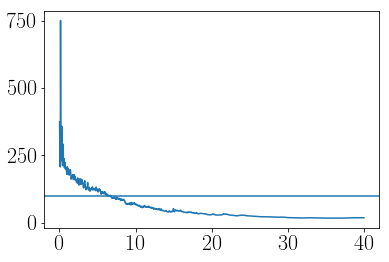

In [95]:
# Look at Slope Monin Obukhov Length as in Ruan et al. 2019
Lo = us**3/(0.4*-Beka)
zs = visc/us
plt.plot(time/86400, Lo/zs)
plt.axhline(100) # Approximate relaminarization point

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(-199.99623505652022, -194.99623505652022)

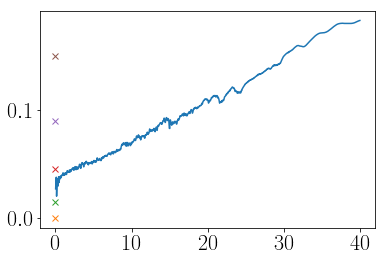

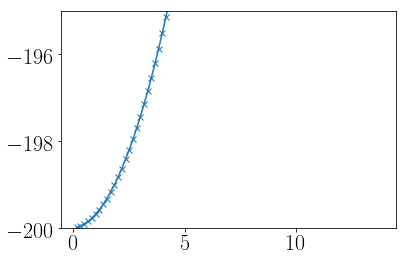

In [96]:
# Plot resolution inside the viscous layer (note Ruan et al. 2019 uses 2 points in 5*deltav)
plt.figure()
plt.plot(time/86400, visc/us)
plt.plot(0, np.transpose(zm[0:5,np.newaxis] - zm[0]), marker='x');

# Plot delta z normalized by viscous units
deltaz = zm[1:] - zm[:-1]
plt.figure()
plt.plot(deltaz/delv, zm[1:], marker='x')
plt.ylim((zm[0], zm[0]+5))

## Calculate the 0 PV layer depth (H)

This code calculates the depth of the zero PV layer using:
\begin{equation}
\frac{\partial H^2}{\partial t} = 2 \frac{B_{Ek}(t)}{N^2}
\end{equation}

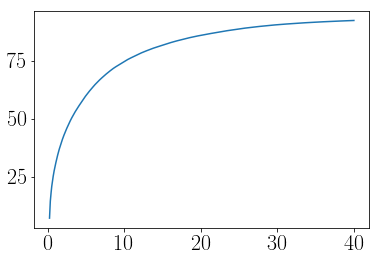

In [97]:
nt = BekD.shape[0]

toff = 12*2 # Starting timestep
Ho = 14 # Pick a starting depth (not necessarily starting at t=0, H=0)

toff = 12
Ho = 5
Ent = 1.0 # Entrainment factor...
H2 = np.zeros((nt, )) 
for i in range(toff, nt):
    H2[i] = H2[i-1]+(2*(1+S2)*Ent*-Beka[i]/(N**2))*(time[i]-time[i-1])
    
H = np.sqrt(Ho**2 + H2)
H[0:toff] = np.nan
plt.plot(time/86400, H)

## Calculate the convective layer depth

See manuscript for details (parameters are hardcoded here from best fits)

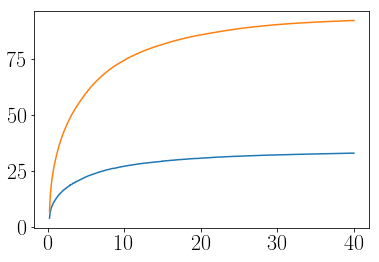

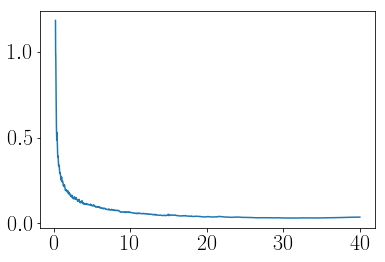

In [98]:
def fithT(ent, H):
    def fithH(factor): #factor is the combined coefficient of the highest order term (ie. Factor*(1-h/h)^3)
        nt = factor.size
        h = np.ones((nt))
        entm = np.mean(ent)
        for i in range(0, nt):
            def f(x):
              return (x-0.35)**2 - 0.1*factor[i]**2*(1-ent[i]*x)

            if np.isfinite(factor[i]):
                h[i], info, ier, n = optimize.fsolve(f, 0.35, maxfev=10000, full_output=True)
                if ier == 0:
                    print('fail')
        return h*H
    return fithH

fact = Lo/H
h = fithT(0*H + 1, H)(fact)
plt.plot(time/86400, h)
plt.plot(time/86400, H)

plt.figure()
plt.plot(time/86400, fact)

## Plot U, N2, and Q as a function of time

## U, V, N2, and Q

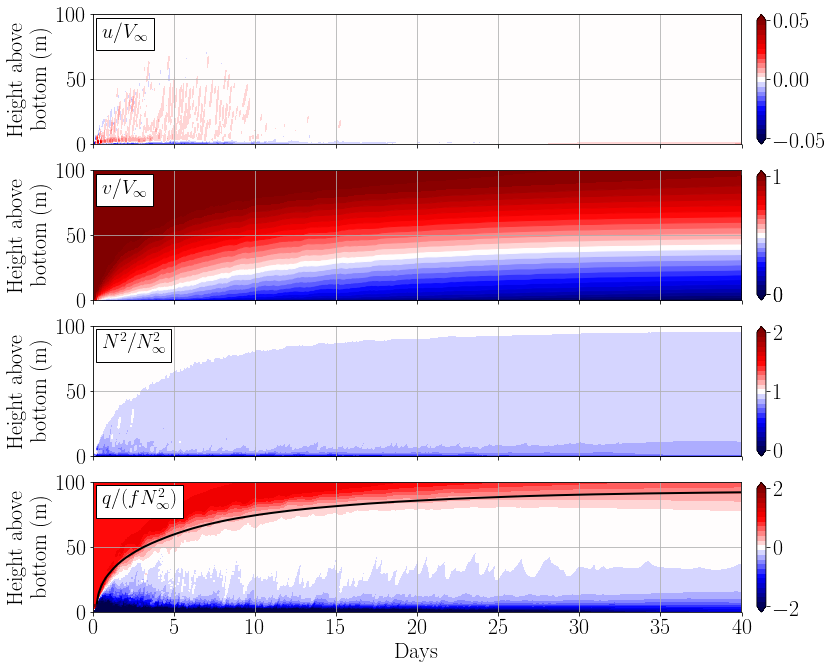

In [99]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from mpl_toolkits.axes_grid1 import make_axes_locatable

loff = 20
xoff = 0.55
asp = 13
pad = 0.02
fig, ax=plt.subplots(4,1, sharex=True, figsize=(14,11), gridspec_kw={'height_ratios': [1,1, 1, 1]})
yl = (zm[0],zm[0]+125)
yl = (z[0], z[0]+100)
#ax[0].plot(time/86400, bflux)
#ax[0].grid()
#plt.colorbar(ax=ax[0])

## CROSS-SLOPE VELOCITY ##
cminv = -0.05
cmaxv = -cminv
ix = ax[0].contourf(time/86400, z, np.transpose(um[:,:])/Vi,np.linspace(cminv, cmaxv, 26), vmin=cminv, vmax=cmaxv, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[0] , ticks=[cminv,0, cmaxv] , aspect=asp, pad=pad)
ax[0].set_ylabel('Height above\n bottom (m)')
bb = dict(boxstyle='Square', fc='w')
ax[0].text(xoff,yl[-1]-loff, '$u/V_\infty$', fontsize=20, bbox=bb)
ax[0].grid()
ax[0].set_ylim(yl)

## ALONG-SLOPE VELOCITY ##
cminv = 0
cmaxv = 1
ix = ax[1].contourf(time/86400, z, np.transpose(vm[:,:]+Vi)/Vi,np.linspace(cminv, cmaxv, 26), vmin=cminv, vmax=cmaxv, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[1] , ticks=[cminv,0, cmaxv] , aspect=asp, pad=pad)
ax[1].set_ylabel('Height above\n bottom (m)')
bb = dict(boxstyle='Square', fc='w')
ax[1].text(xoff,yl[-1]-loff, '$v/V_\infty$', fontsize=20, bbox=bb)
ax[1].grid()
ax[1].set_ylim(yl)
for c in ix.collections:
    c.set_edgecolor("face")

## BUOYANCY ##
cmin = 0
cmax = 2
ix = ax[2].contourf(time/86400, z, np.transpose(bz[:,:])/N**2,np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[2] , ticks=[cmin,1, cmax] , aspect=asp, pad=pad)
ax[2].set_ylabel('Height above\n bottom (m)')#ax[1].set_title('$N^2/N^2_o$')
ax[2].set_ylim(yl)
ax[2].grid()
ax[2].text(xoff, yl[-1]-loff, '$N^2/N^2_\infty$', fontsize=20, bbox=bb)
#ax[0].plot(time/86400, -Hd)
for c in ix.collections:
    c.set_edgecolor("face")
    
## POTENTIAL VORTICITY ##

cmin = -2
cmax = 2
ix = ax[3].contourf(time/86400, z, np.transpose(qm[:,:])/(1e-4*N**2), np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[3] , ticks=[cmin, 0, cmax], aspect=asp, pad =pad)
ax[3].set_xlabel('Days')
ax[3].set_ylabel('Height above\n bottom (m)')
#ax[2].set_title('q')
ax[3].plot(time/86400, H, linewidth = 2, color='k')
#ax[3].plot(time/86400, h, linewidth = 1, color='k', linestyle = '--')

ax[3].set_ylim(yl)
ax[3].text(xoff, yl[-1]-loff, '$q/(fN^2_\infty)$', fontsize=20, bbox=bb)
ax[3].grid()
for c in ix.collections:
    c.set_edgecolor("face")

if SAVEFLAG:
    plt.savefig(f'./MSFigs/Overview4Panel_{NameAppend}.pdf', bbox_inches='tight')

## Cross-frontal slice plot

Make figure showing the SI overturning cells and buoyancy field.

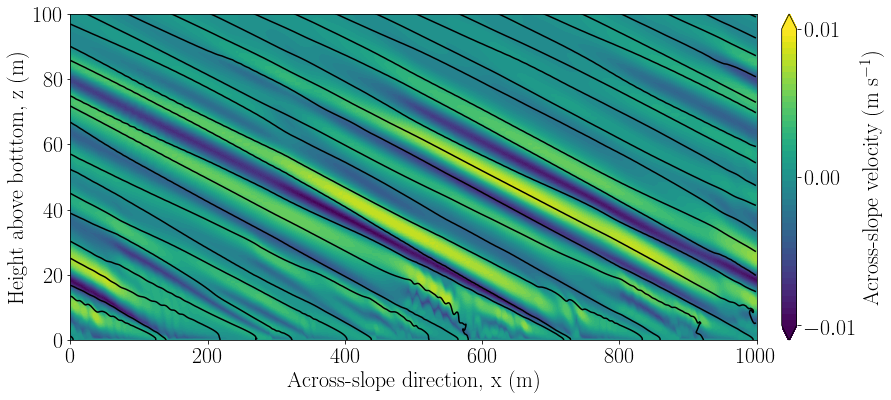

In [100]:
ti = -1;
ti = np.where(time/86400>12)[0][0]
cmin = -0.01
cmax = -cmin
cmap = 'viridis'

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(15, 6), gridspec_kw = {'width_ratios':[4]})
ix = ax.contourf(x, zm-zm[0], np.transpose(u[ti,:,:]), np.linspace(cmin, cmax, 50), vmin = cmin, vmax =cmax,cmap = cmap, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
#cbaxes = inset_axes(ax, width="30%", height="6%", loc=1, borderpad=0.5, axes_kwargs={'facecolor':'lightgrey'}) 

#cb = plt.colorbar(ix, cax=cbaxes, orientation='horizontal', ticks=[cmin, cmax])
cb = plt.colorbar(ix, ticks=[cmin, 0, cmax], pad=0.03)

cb.set_label('Across-slope velocity (m s$^{-1}$)',  color='k')
#cbaxes.tick_params(labelcolor='w', labelsize=18)
cb.solids.set_edgecolor("face")

ax.contour(x, zm-zm[0], np.transpose(bf[ti,:,:]), 50, colors='k')

ax.set_xlabel('Across-slope direction, x (m)')
ax.set_ylim((0, 100))
ax.set_xticks([0, 200, 400, 600, 800, 1000])
ax.set_ylabel('Height above botttom, z (m)')

if SAVEFLAG:
    plt.savefig(f'./MSFigs/Slice_{NameAppend}.pdf', bbox_inches='tight')

## MOMENTUM BUDGET

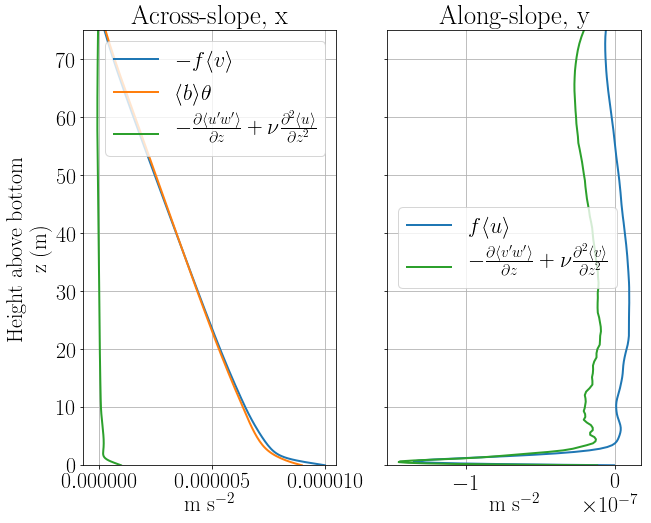

In [101]:
# Plot the mean across and along slope momentum budget
ti = np.where((time/86400>9) & (time/86400<11))[0] # Pick the time range to average over

fig, ax = plt.subplots(1,2,figsize=(10,8),sharey=True)
TEND = (um[ti[-1], :] - um[ti[0],:])/(time[ti[-1]] - time[ti[0]])
COR = -1e-4*np.mean(vm[ti,:], axis=0)
BUOY = np.mean(bm[ti,:], axis=0)*tht
uz = np.gradient(np.mean(um[ti,:], axis=0))/np.gradient(z)
uzz = np.gradient(uz)/np.gradient(z)
VISC = 1e-4*uzz-np.gradient(np.mean(upwp[ti,0,:], axis=0))/np.gradient(z)
ax[0].plot(COR, z,linewidth=2, label=r'$-f\langle v \rangle$')
ax[0].plot(BUOY, z,linewidth=2, label=r'$\langle b \rangle \theta$')
ax[0].plot(VISC, z,linewidth=2, label=r'$-\frac{\partial \langle u^\prime w^\prime\rangle}{\partial z} +\nu \frac{\partial ^2 \langle u \rangle}{\partial z^2}$')
#plt.plot(TEND, z)
#ax[0].plot(-COR + BUOY+VISC, z, linestyle = '--', label='SUM')
ax[0].set_ylim(0, 75)
ax[0].set_ylabel('Height above bottom\n z (m)')
ax[0].legend()
ax[0].grid()
ax[0].set_title('Across-slope, x')
ax[0].set_xlabel('m s$^{-2}$')
#Along-slope
TEND = (vm[ti[-1], :] - vm[ti[0],:])/(time[ti[-1]] - time[ti[0]])

COR = 1e-4*np.mean(um[ti,:], axis=0)
vz = np.gradient(np.mean(vm[ti,:], axis=0))/np.gradient(z)
vzz = np.gradient(vz)/np.gradient(z)
VISC = 1e-4*vzz-np.gradient(np.mean(vpwp[ti,:], axis=0))/np.gradient(z)
ax[1].plot(COR, z, label=r'$f\langle u \rangle$', linewidth=2)
plt.plot(0, 0) # keep same coloring between subplots
ax[1].plot(VISC, z,linewidth=2, label=r'$-\frac{\partial \langle v^\prime w^\prime\rangle}{\partial z} +\nu \frac{\partial ^2 \langle v \rangle}{\partial z^2}$')

#ax[1].plot(-COR +VISC, z, linestyle = '--', label='SUM')
ax[1].set_ylim(0, 75)
ax[1].legend()
ax[1].grid()
ax[1].set_title('Along-slope, y')
ax[1].set_xlabel('m s$^{-2}$')
#ax[1].set_xlim(-8e-7, 2e-7)
if SAVEFLAG:
    plt.savefig(f'./MSFigs/MomBudget_{NameAppend}.pdf', bbox_inches='tight')

## PSEUDO-GSP and BUOYANCY FLUX


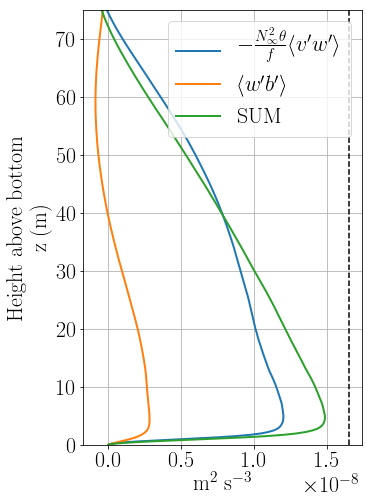

In [102]:
# Plot the mean across and along slope momentum budget
ti = np.where((time/86400>9) & (time/86400<11))[0] # Pick the time range to average over

fig, ax = plt.subplots(1,1,figsize=(5,8),sharey=True)

GSP = np.mean(-gspr[ti,0,:], axis=0)
#GSP = np.gradient(np.mean(-gspr[ti,0,:], axis=0))/np.gradient(z)
VBF = np.mean(vbfrot[ti,0,:], axis=0)
#VBF = np.gradient(np.mean(vbfrot[ti,0,:], axis=0))/np.gradient(z)

ax.plot(GSP, z, label=r'$-\frac{N^2_\infty \theta}{f}\langle v^\prime w^\prime \rangle$', linewidth=2)
ax.plot(VBF, z, label=r'$\langle w^\prime b^\prime \rangle$', linewidth=2)
ax.plot(GSP+VBF, z, label='SUM', linewidth=2)
#ax.plot(np.mean(wq[ti,0,:], axis=0)*1e4, z)
ax.axvline(-np.mean((1+S2)*Beka[ti]), linestyle='--', color='k')
#ax.axhline(np.mean(H[ti]))
ax.set_ylim(0, 75)
ax.set_ylabel('Height above bottom\n z (m)')
ax.legend()
ax.grid()
ax.set_xlabel('m$^2$ s$^{-3}$')

if SAVEFLAG:
    plt.savefig(f'./MSFigs/GSPFLUX_{NameAppend}.pdf', bbox_inches='tight')

## ENERGY BUDGET

NameError: name 'EKETEST' is not defined

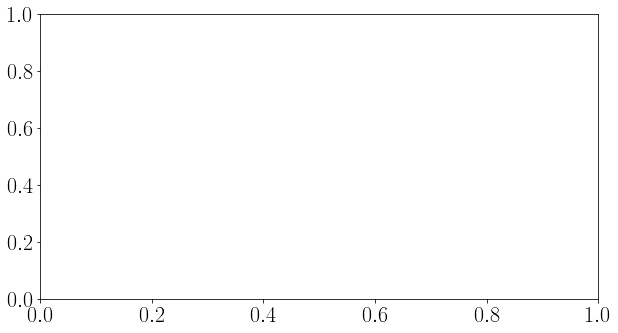

In [103]:
#EKE Fancy 2 panel


plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
# Bekfull = -Bek[:,np.newaxis]*((zm[np.newaxis,:]-zm[0])/(H[:,np.newaxis]) -1 )/(1+N**2*np.tan(tht[0,0,0])**2/1e-8)
# Bekfull[Bekfull> 0 ] = 0
# Bekfull[np.isnan(Bekfull)] = 0

    
# bdrag = (vm[:,0])*tauy/(1030)
# damp = -0.005*((-20 - (z-z[-1]))/20)**2
# damp[(z[:]-z[-1])<-20] = 0

# damp = np.mean(damp*up*up + damp*vp*vp + damp*w[:,:,:]**2, axis=1)

startind=48*0
zl = np.where((z>0) & (z<=z[-1]))[0]
# bdrag = -1e-4*(EKE[:,0,1] - EKE[:,0,0])/(z[1]-z[0])
# plt.figure(figsize=(14,8))
fig, ax = plt.subplots(1, 1, sharey=False, figsize=(10, 5.25), gridspec_kw = {'width_ratios':[4]})

EKI = integrate.trapz(EKE[startind:,0,zl], x=z[zl], axis=-1)  - integrate.trapz(EKETEST[startind:,0,zl], x=z[zl], axis=-1)[0]
# DRAGI = integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0)
# DRAGSI = integrate.cumtrapz(bdrags[startind:], x=time[startind:], initial=0)
#DAMPI = integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

# wzdiss = 1e-4*np.mean((np.gradient(w, axis=-1)/np.gradient(z[np.newaxis,np.newaxis,:], axis=-1))**2, axis=1)
DISSI = integrate.cumtrapz(integrate.trapz(diss[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
SPI = -integrate.cumtrapz(integrate.trapz(sp[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
EKEEPEI = integrate.cumtrapz(integrate.trapz(vbfr[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
# BSCALE = integrate.cumtrapz(integrate.trapz(Bekfull[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

SUM =  DISSI + SPI + EKEEPEI

# ax[0].plot(time[startind:]/86400, EKI, label='EKE', linewidth=2)

ax.plot(time[startind:]/86400, SPI, label='$\int_0^t$ Shear production', linewidth=2)
# plt.plot(time[startind:]/86400, integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0), label='$Damp$')
ax.plot(time[startind:]/86400, DISSI, label='$\int_0^t$ Dissipation', linewidth=2)
# plt.plot(time[startind:]/86400, DAMPI, label='$\int_0^t DAMP$')

# # plt.plot(time/86400, np.sqrt(S)*N*H/(2*(1+S)*ubt)*dissi, label='Scaling')
# ax[0].plot(time[startind:]/86400, -integrate.cumtrapz(H[startind:]*Beka[startind:]/2, x=time[startind:], initial=0), label='Scaling')
# plt.plot(time[startind:]/86400, DRAGI, label='Drag')
# plt.plot(time[startind:]/86400, DRAGSI, label='Drag Scaling')

# plt.plot(time[startind:]/86400, integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0), label='Drag')
ax.plot(time[startind:]/86400, EKEEPEI, label='$\int_0^t$ Vertical buoyancy production', linewidth=2)
ax.plot(time[startind:]/86400, EKI, label='EKE', linewidth=2)
# ax[0].plot(time[startind:]/86400, integrate.cumtrapz(H[startind:]*Beka[startind:]/2, x=time[startind:], initial=0), 
#            label='Scaling')

# plt.plot(time[startind:]/86400, BSCALE, label='$\int_0^t$ Ekman buoyancy flux', linewidth=2)

# plt.plot(time[startind:]/86400, SUM, linestyle='dashed', label='SUM RHS')
# ax[0].legend()
ax.grid()
ax.set_title('Cumulative EKE budget')
ax.set_xlim((0, 45))
ax.set_xlabel('Days')
ax.set_ylabel('m$^3$s$^{-2}$')
# plt.ylim((-2e-2, 2e-2))
ax.set_ylim(-0.25, 0.25)
ti = np.where((time/86400>10) & (time/86400<15))[0]


# Add annotations
ax.annotate("$ \Delta EKE$",
            xy=(13, 0.0), xycoords='data',
            xytext=(12.1, 0.05), textcoords='data',
            color='#d62728',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='#d62728'),
            )
ax.annotate("Buoyancy Production",
            xy=(10.5, -0.005), xycoords='data',
            xytext=(8.2, -0.075), textcoords='data',
            color='#2ca02c',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='#2ca02c'),
            )
ax.annotate("Shear Production",
            xy=(5.5, 0.13), xycoords='data',
            xytext=(0.8, 0.14), textcoords='data',
            color='#1f77b4',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='#1f77b4'),
            )
ax.annotate("Dissipation",
            xy=(5.5, -0.13), xycoords='data',
            xytext=(2.1, -0.16), textcoords='data',
            color='#ff7f0e',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='#ff7f0e'),
            )
plt.tight_layout()

if SAVEFLAG:
    plt.savefig(f'./MSFigs/EnergyCumulative_{NameAppend}.pdf', bbox_inches='tight')


## SPECTRAL DOMAIN


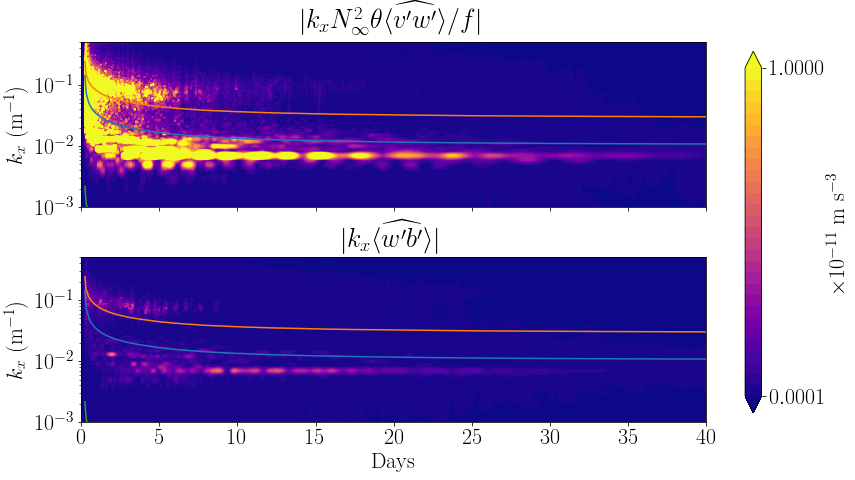

In [104]:
#%% v'w' and w'b' averaged over the BBL depth
cmin = -5e-12
cmax = -cmin
cmin = 1e-4
cmax = 1
nc = 30
cm = 'plasma'
nt, nk, nz = wvs.shape
LScale = np.zeros((nt,))
wvsi = np.zeros((nk,nt))
wbsi = np.zeros((nk,nt))

for i in range(0,nt):
    #indl = np.argmin(np.abs(z-h[i]))
    indl = np.argmin(np.abs(z-0))
    indu = np.argmin(np.abs(z-H[i]))
    if indu <= indl:
        indu = indl+2
    zl = np.arange(indl, indu)
    SlopeI = np.arctan2(N**2*tht,N**2 + (bm[i,indu] - bm[i,indl])/(z[indu]-z[indl]))
    SlopeI = tht/S2
    LScale[i] = np.abs(0.65*H[i]/SlopeI)
    wvsi[:,i] = 1e11*np.abs((integrate.trapz(np.real(kx[np.newaxis,:]*wvs[i,:,zl]*N**2*tht/(1e-4))
                                                    ,x=z[zl], axis=0))/(zm[zl[-1]]-zm[zl[0]]))
    wbsi[:,i] = 1e11*np.abs((integrate.trapz(np.real(kx[np.newaxis,:]*wbs[i,:,zl])
                                                    ,x=z[zl], axis=0))/(zm[zl[-1]]-zm[zl[0]]))
    #wvsi[:,i] = np.abs((integrate.trapz(np.real(wvs[i,:,zl]*N**2*tht/(1e-4))
    #                                                ,x=z[zl], axis=0))/(zm[zl[-1]]-zm[zl[0]]))
    #wbsi[:,i] = np.abs((integrate.trapz(np.real(wbs[i,:,zl])
    #                                                ,x=z[zl], axis=0))/(zm[zl[-1]]-zm[zl[0]]))
fig, ax = plt.subplots(2,1,sharex=True, figsize=(14,7))
ix = ax[0].contourf(time/86400, kx, (wvsi),np.linspace(cmin, cmax, nc), cmap = cm, vmin=cmin, vmax=cmax, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
ax[0].set_yscale('log')
ax[0].set_ylim((kx[1], kx[-1]))
ax[0].set_ylabel('$k_x$ (m$^{-1}$)')
ax[0].set_title(r'$|k_xN^2_\infty \theta \widehat{\langle v^\prime w^\prime\rangle}/f|$')
ax[0].plot(time/86400, 1/H)
ax[0].plot(time/86400, 1/h)
ax[0].plot(time/86400, 1/LScale)

ix = ax[1].contourf(time/86400, kx, (wbsi), np.linspace(cmin, cmax, nc), cmap = cm, vmin=cmin, vmax=cmax, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
ax[1].set_yscale('log')
ax[1].set_ylim((kx[1], kx[-1]))
ax[1].set_xlabel('Days')
ax[1].set_ylabel('$k_x$ (m$^{-1}$)')
ax[1].set_title('$|k_x\widehat{\langle w^\prime b^\prime\\rangle}|$')
ax[1].plot(time/86400, 1/H)
ax[1].plot(time/86400, 1/h)
#ax[1].plot(time/86400, 1/(0.35*H))
ax[1].plot(time/86400, 1/(LScale))
plt.subplots_adjust(hspace=0.3)

cb = fig.colorbar(ix, ax=ax.ravel().tolist(), shrink=0.95)
cb.set_ticks([cmin, cmax])
cb.set_label('$\\times 10^{-11}$ m s$^{-3}$')

#SAVEFLAG=True
#NameAppned = 'CI-1-LRG'
if SAVEFLAG:
    plt.savefig(f'./MSFigs/Spectrogram_{NameAppend}.pdf', bbox_inches='tight')


In [ ]:
wvs.shape

In [ ]:
# Divide into high/low wavenumber (nt x nz)
kcut = np.where(kx<1e-2)[0]
kcut = kcut[-1]
gsps = -wvs*N**2*tht/(1e-4)
vbfs = wbs
gspl = np.sum(gsps[:,1:kcut,:], axis=1)
gsph = np.sum(gsps[:,kcut:,:], axis=1)
vbfl = np.sum(vbfs[:,1:kcut,:], axis=1)
vbfh = np.sum(vbfs[:,kcut:,:], axis=1)

vbfh.shape

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

cmin = -3e-0
cmax = -cmin
zl = 75
zoff = 16
xoff = 0.75
cmap = 'Spectral_r'
cmap = 'seismic'
fig, ax = plt.subplots(4,1,sharex=True, figsize=(9,9))

im = ax[0].pcolormesh(time/86400, z, 1e9*np.transpose(vbfl), vmin = cmin, vmax=cmax, cmap=cmap)
#im.set_edgecolor('face')
ax[0].set_ylabel('z [m]')
ax[0].set_ylim(0, zl)
ax[0].plot(time/86400, H, color='k')
ax[0].plot(time/86400, h, color='k', linestyle='--')
bb = dict(boxstyle='Square', fc='w')
ax[0].text(xoff,zl - zoff, '$VBF_{\lambda > 100m}$', fontsize=20, bbox=bb)
ax[0].set_yticks([0, 25, 50, 75])
ax[0].grid()

im = ax[1].pcolormesh(time/86400, z, 1e9*np.transpose(vbfh), vmin = cmin, vmax=cmax, cmap=cmap)
#im.set_edgecolor('face')
ax[1].set_ylabel('z [m]')
ax[1].set_ylim(0, zl)
ax[1].plot(time/86400, H, color='k')
ax[1].plot(time/86400, h, color='k', linestyle='--')
ax[1].text(xoff,zl - zoff, '$VBF_{\lambda < 100m}$', fontsize=20, bbox=bb)
ax[1].set_yticks([0, 25, 50, 75])
ax[1].grid()

im = ax[2].pcolormesh(time/86400, z, 1e9*np.transpose(gspl), vmin = cmin, vmax=cmax, cmap=cmap)
#im.set_edgecolor('face')
ax[2].set_ylabel('z [m]')
ax[2].set_ylim(0, zl)
ax[2].plot(time/86400, H, color='k')
ax[2].plot(time/86400, h, color='k', linestyle='--')
ax[2].text(xoff,zl - zoff, '$GSP_{s,\;\lambda > 100m}$', fontsize=20, bbox=bb)
ax[2].set_yticks([0, 25, 50, 75])
ax[2].grid()

im = ax[3].pcolormesh(time/86400, z, 1e9*np.transpose(gsph), vmin = cmin, vmax=cmax, cmap=cmap)
#im.set_edgecolor('face')
ax[3].set_ylabel('z [m]')
ax[3].set_ylim(0, zl)
ax[3].plot(time/86400, H, color='k')
ax[3].plot(time/86400, h, color='k', linestyle='--')
ax[3].set_xlabel('Days')
ax[3].text(xoff,zl - zoff, '$GSP_{s,\;\lambda < 100m}$', fontsize=20, bbox=bb)
ax[3].set_yticks([0, 25, 50, 75])
ax[3].grid()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, extend='both')
cb.set_label('$\\times 10^{-9}$ m$^2$ s$^{-3}$')

if SAVEFLAG:
    plt.savefig(f'./MSFigs/SpecFluxByDepth_{NameAppend}.pdf', bbox_inches='tight')


(0, 40)

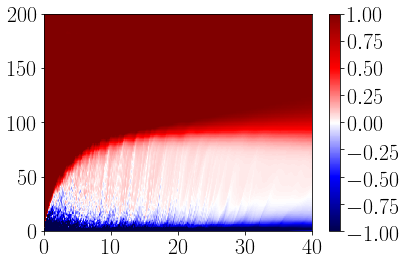

In [106]:
# Look at the absolute vertical vorticity
vgz = -bz_prime/1e-4*np.tan(tht)
vrelvort = -vgz*np.sin(tht)
vrelvort = -(np.gradient(vm, axis=-1)/np.gradient(z))*np.sin(tht)
plt.pcolor(time/86400, z, np.transpose(1e-4+vrelvort)/1e-4, vmin=-1, vmax=1, cmap='seismic')
plt.colorbar()
plt.xlim(0,40)

In [ ]:
#plt.plot(vrelvort[-1,:]/1e-4, z)

plt.plot(vgz[-1,:], z)
plt.plot(np.gradient(vm[-1,:])/np.gradient(z), z)

In [ ]:
fact = N**2*(1-1/(1+S2))
plt.pcolormesh(time/86400, z, np.transpose(bz/fact))
plt.colorbar()

plt.contour(time/86400, z, np.transpose(bz/fact), (1,), colors='w')

plt.xlim(0, 5)

In [ ]:
time[100]/86400

In [ ]:
plt.plot(bz[150,:]/fact, z)